## Check if there is a 1-to-1 correspondence between: DES and WISE, DES and IRAC

In [1]:
import numpy as np
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_probability as tfp
tfd = tfp.distributions
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from tensorflow.keras.models import load_model, Sequential, Model

# Activate TF2 behavior:
from tensorflow.python import tf2
if not tf2.enabled():
    import tensorflow.compat.v2 as tf
    tf.enable_v2_behavior()
    assert tf2.enabled()

np.random.seed(12211)  

%load_ext line_profiler
%reload_ext autoreload
%autoreload 1
%aimport help_funcs
%aimport help_train
#import help_funcs_zeropt as help_funcs
#import help_train_zeropt as help_train # Wait, when did we start doing this instead of the line profiler?
import zeropoints_new as zeropoints
import SetPub
SetPub.set_pub()

In [2]:
Trainset = ['FSPSlin', 'FSPSlog', 'FSPSall', 'OBS', 'UM', 'BP', 'UMnew'][6] # Soon there will be more!
# Testset = ['FSPSlin', 'FSPSlog', 'FSPSall', 'OBS', 'UM', 'BP', 'UMnew'][3]
Testset = ['FSPSlin', 'FSPSlog', 'FSPSall', 'OBS', 'UM', 'BP', 'UMnew', 'OBSuq'][7] # Test on the same things we tested before (SDSS)
surveystring = ['SDSS', 'VIPERS', 'DEEP2', 'PRIMUS']

In [12]:
%%time
sim_list = ['des', 'wise']
y_test_lst = []
for sim in sim_list:
    train_dirIn = '/data/a/cpac/nramachandra/Projects/phoZ/Synthetic_Data/fsps_wrapper/notebooks/out/rand_z/'
    #test_dirIn = '/data/a/cpac/aurora/MDN_phoZ/Data/fromGalaxev/photozs/datasets/data_feb_2021/'
    X_train, y_train, X_test, y_test = help_train.loadTrainTest_custom_randz(Testset, sim, train_dirIn, frac_train = 0.5) # Need X_err and test_labels
    y_test_lst.append(y_test)
print(len(y_test_lst))

Training on sim:  des
X training data shape:  (2000000, 5)
y training data shape:  (2000000,)
----------
number of datapoints:  2000000
z-minmax:  0.019267627842316573 2.973513536413443
ColMag-min:  [-0.19  -0.151 -0.137 -0.085 12.315]
ColMag-max:  [ 2.422  1.593  1.163  0.668 32.503]
----------
----------
number of datapoints:  1000000
z-minmax:  0.019267627842316573 2.973513536413443
ColMag-min:  [-0.19  -0.151 -0.137 -0.085 12.315]
ColMag-max:  [ 2.422  1.593  1.163  0.668 32.503]
----------
Training on sim:  wise
X training data shape:  (2000000, 4)
y training data shape:  (2000000,)
----------
number of datapoints:  2000000
z-minmax:  0.019267627842316573 2.973513536413443
ColMag-min:  [-0.656 -1.749 -1.467 11.329]
ColMag-max:  [ 0.194 -0.455 -1.113 32.105]
----------
----------
number of datapoints:  1000000
z-minmax:  0.019267627842316573 2.973513536413443
ColMag-min:  [-0.656 -1.749 -1.467 11.329]
ColMag-max:  [ 0.194 -0.456 -1.113 32.105]
----------
2
CPU times: user 3.11 s, s

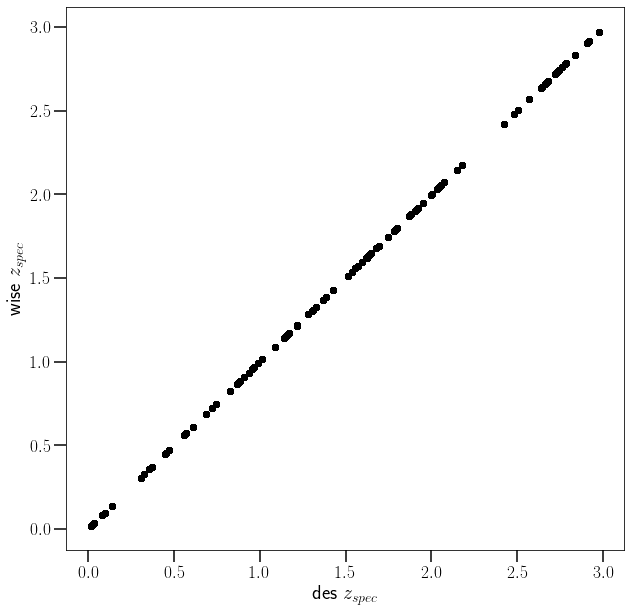

In [13]:
#plt.rcParams['agg.path.chunksize'] = 1000000000000000000000000000000000000000000
fig, ax = plt.subplots(figsize=(10, 10,))
ax.scatter(y_test_lst[0], y_test_lst[1], label = sim_list[0] + " vs. " + sim_list[1], c = 'k') # , fmt = 'o', marker=None, ms = 4, alpha = 0.3,
ax.set_xlabel(sim_list[0] + r" $z_{spec}$", fontsize = 20)
ax.set_ylabel(sim_list[1] + r" $z_{spec}$", fontsize = 20)
fig.savefig(sim_list[0] + "_" + sim_list[1] + "_compare.png")

In [ ]:
D = X_train.shape[1]
    K = 3
    
    save_mod = '/data/a/cpac/aurora/MDN_phoZ/saved_hubs/tf2models/'+'Train_'+Trainset+'_lr_'+str(learning_rate)+'_dr'+str(decay_rate)+'_ne'+str(n_epochs)+'_k'+str(K)+'_nt'+str(num_train)
    
    # Now, we are training models

    from sklearn.pipeline import Pipeline
    from sklearn.preprocessing import StandardScaler, MinMaxScaler
    import pickle

    # This preproc stuff is related to "scaling routine" -- right? Yes :)
    preproc = Pipeline([('stdscaler', StandardScaler())]) # This preproc tool is what allows us to transform inputs into min-max space (and therefore to feed it to the trained model)
    # preproc = Pipeline([('stdscaler', MinMaxScaler())])
    X_train = preproc.fit_transform(X_train) # Not sure how "fit_transform" is different from the original "transform"?

    scalerfile = save_mod + '_scaling_X'
    pickle.dump(preproc, open(scalerfile, 'wb'))
    preproc = pickle.load(open(scalerfile, 'rb'))

    X_test = preproc.transform(X_test) # This transformation puts our input into min-max space

    # preproc_y = Pipeline([('stdscaler', StandardScaler())])
    preproc_y = Pipeline([('stdscaler', MinMaxScaler())])

    y_train = preproc_y.fit_transform(y_train.reshape(-1, 1))

    scalerfile = save_mod + '_scaling_y'
    pickle.dump(preproc_y, open(scalerfile, 'wb'))
    preproc_y = pickle.load(open(scalerfile, 'rb'))

    y_test = preproc_y.transform(y_test.reshape(-1, 1))